In [105]:
df_tcell = pd.read_csv("tcell_virus_tetramer.csv");
df_tcell

,allele,peptide,fraction_entries_positive,num_entries,num_entries_with_subjects,num_subjects,num_subjects_positive,fraction_subjects_positive,in_sars2,species_prefix,species,mhc_gene_name,mhc_class
0,H2-Db,AAIENYVRF,1.000000,1,0,0.0,0.0,0.000000,False,H2,mouse,D,I
1,H2-Db,AAVKNWMTQTL,1.000000,1,0,0.0,0.0,0.000000,False,H2,mouse,D,I
2,H2-Db,AGPHNDMEI,0.863636,22,2,18.0,16.0,0.888889,False,H2,mouse,D,I
3,H2-Db,ASNENMDAM,0.578947,19,0,0.0,0.0,0.000000,False,H2,mouse,D,I
4,H2-Db,ASNENMDTM,1.000000,3,0,0.0,0.0,0.000000,False,H2,mouse,D,I
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2620,SLA-2*0401,MTAHITVPY,1.000000,1,1,4.0,4.0,1.000000,False,SLA,pig,2,?
2621,SLA-2*0401,SKFTFSIPY,0.000000,1,1,5.0,0.0,0.000000,False,SLA,pig,2,?
2622,SLA-2*0401,SSVGVTHGY,1.000000,1,1,4.0,4.0,1.000000,False,SLA,pig,2,?
2623,SLA-2*0401,TNTQNNDWF,1.000000,1,1,5.0,5.0,1.000000,False,SLA,pig,2,?


In [132]:
df_tcell_class2 = df_tcell[df_tcell["mhc_class"] == "II"]
df_tcell_class2_negative = df_tcell_class2[df_tcell_class2.fraction_entries_positive <= 0.5]
df_tcell_class2_positive = df_tcell_class2[df_tcell_class2.fraction_entries_positive > 0.5]
print("Negative:\n%s\n" % (df_tcell_class2_negative.allele.value_counts(),))
print("Positive:\n%s" % (df_tcell_class2_positive.allele.value_counts(),))

Negative:
HLA-DRB1*04:01    128
HLA-DRB1*01:02     61
HLA-DRB1*03:01     61
HLA-DRB1*04:04     55
HLA-DRB1*15:01     12
HLA-DRB5*01:01     10
HLA-DRB1*01:03      8
HLA-DRB1*01:01      6
H2-IAb              2
HLA-DRB1*11:01      2
HLA-DRB1*08:01      1
HLA-DRB1*07:01      1
H2-IA               1
Name: allele, dtype: int64

Positive:
HLA-DRB1*01:01     148
HLA-DRB1*04:01     135
HLA-DRB1*11:01     126
HLA-DRB1*07:01     119
HLA-DRB1*04:04      86
HLA-DRB1*15:01      85
HLA-DRB1*03:01      67
HLA-DRB5*01:01      65
HLA-DRB1*01:03      25
H2-IAb              20
HLA-DRB1*11:04      18
HLA-DRB1*08:01      15
HLA-DRB1*15:02      12
HLA-DRB1*14:01      11
HLA-DRB1*13:01       8
HLA-DRB3*02:02       7
HLA-DRB1*01:02       4
HLA-DRB1*13:02       3
H2-IAd               3
HLA-DRB1*09:01       3
HLA-DQB1*06:02       3
HLA-DRB1*12:01       2
HLA-DRB3*01:01       1
HLA-DPB1*04:01       1
Patr-DRB5*03:10      1
Name: allele, dtype: int64


In [107]:
df_tcell.fraction_entries_positive.isnull().mean()

0.0

In [108]:
import mhcflurry
from mhctools import MHCflurry
pred = mhcflurry.Class1PresentationPredictor.load()
supported_alleles = set(pred.supported_alleles)

df_tcell["mhcflurry_allele_name"] = df_tcell.allele.str.replace("H2", "H-2")

df_tcell_mouse_and_human = df_tcell[df_tcell.species.isin({"human", "mouse"})]

df_tcell_mouse_and_human_class1 = df_tcell_mouse_and_human[
    df_tcell_mouse_and_human.mhc_class == "I"]

df_tcell_mhcflurry = df_tcell_mouse_and_human_class1[
    (df_tcell_mouse_and_human_class1.mhcflurry_allele_name.isin(supported_alleles)) &
    (df_tcell_mouse_and_human_class1.peptide.str.len() < 16)]

print("Selected %d/%d pMHCs for prediction with MHCflurry" % (
    len(df_tcell_mhcflurry),
    len(df_tcell)))
print("%0.2f%% of label values null" % (
    df_tcell_mhcflurry.fraction_entries_positive.isnull().mean() * 100))


Selected 1214/2625 pMHCs for prediction with MHCflurry
0.00% of label values null


In [135]:
df_pred_mhcflurry = pred.predict(
    peptides=df_tcell_mhcflurry.peptide.values,
    alleles={allele:[allele] for allele in df_tcell_mhcflurry.mhcflurry_allele_name.unique()},
    sample_names=df_tcell_mhcflurry.mhcflurry_allele_name.values)
df_pred_mhcflurry.to_csv("tcell_virus_tetramer_class1_mhcflurry_predictions.csv", index=False)
print(len(df_pred), len(df_tcell_mhcflurry))

  0%|          | 0/1 [00:00<?, ?it/s]

Predicting processing.


  1%|▏         | 1/68 [00:00<00:07,  9.50it/s]

Predicting affinities.


100%|██████████| 68/68 [00:06<00:00, 10.81it/s]

1214 1214


In [148]:

from collections import OrderedDict
columns = OrderedDict([
    ("allele", []),
    ("peptide", []),
    ("netmhcpan4_el", []),
    ("netmhcpan4_el_rank", []),
    ("netmhcpan4_ba", []),
    ("netmhcpan4_ba_score", []),
    ("netmhcpan4_ba_rank", []),
])

from mhctools import NetMHCpan4

for allele, group in df_tcell_mhcflurry.groupby("allele"):
    print("==> %s (n=%d)" % (allele, len(group)))
    if allele == "H2-Dk":
        continue
    netmhcpan4_ba = NetMHCpan4(
        alleles=[allele],
        program_name="NetMHCpan-4.0", mode="binding_affinity")
    netmhcpan4_el = NetMHCpan4(
        alleles=[allele],
        program_name="NetMHCpan-4.0", mode="elution_score")
    
    for x_ba, x_el in zip(
            netmhcpan4_ba.predict_peptides(list(group.peptide)), 
            netmhcpan4_el.predict_peptides(list(group.peptide))):
        p = x_ba.peptide
        assert x_el.peptide == p
        
        columns["allele"].append(allele)
        columns["peptide"].append(p)
        columns["netmhcpan4_el"].append(x_el.score)
        columns["netmhcpan4_el_rank"].append(x_el.percentile_rank)
        columns["netmhcpan4_ba"].append(x_ba.affinity)
        columns["netmhcpan4_ba_score"].append(x_ba.score)
        columns["netmhcpan4_ba_rank"].append(x_ba.percentile_rank)
df_pred_netmhcpan4 = pd.DataFrame(columns)
df_pred_netmhcpan4.to_csv("tcell_virus_tetramer_class1_netmhcpan4_predictions.csv", index=False)
print(len(df_pred_mhcflurry), len(df_pred_netmhcpan4))

==> H2-Db (n=60)
==> H2-Dd (n=12)
==> H2-Dk (n=1)
==> H2-Kb (n=73)
==> H2-Kd (n=24)
==> H2-Kk (n=1)
==> H2-Ld (n=10)
==> HLA-A*01:01 (n=33)
==> HLA-A*02:01 (n=426)
==> HLA-A*02:02 (n=2)
==> HLA-A*02:03 (n=3)
==> HLA-A*02:05 (n=9)
==> HLA-A*02:06 (n=13)
==> HLA-A*02:07 (n=4)
==> HLA-A*03:01 (n=21)
==> HLA-A*11:01 (n=41)
==> HLA-A*23:01 (n=6)
==> HLA-A*24:02 (n=40)
==> HLA-A*25:01 (n=9)
==> HLA-A*26:01 (n=7)
==> HLA-A*29:01 (n=1)
==> HLA-A*29:02 (n=11)
==> HLA-A*30:01 (n=1)
==> HLA-A*31:01 (n=5)
==> HLA-A*32:01 (n=15)
==> HLA-A*33:01 (n=1)
==> HLA-A*33:03 (n=6)
==> HLA-A*68:01 (n=11)
==> HLA-A*68:02 (n=2)
==> HLA-B*07:02 (n=94)
==> HLA-B*08:01 (n=22)
==> HLA-B*08:02 (n=3)
==> HLA-B*13:02 (n=4)
==> HLA-B*14:02 (n=3)
==> HLA-B*15:01 (n=29)
==> HLA-B*15:02 (n=3)
==> HLA-B*18:01 (n=8)
==> HLA-B*27:01 (n=1)
==> HLA-B*27:02 (n=2)
==> HLA-B*27:04 (n=1)
==> HLA-B*27:05 (n=13)
==> HLA-B*35:01 (n=48)
==> HLA-B*35:02 (n=1)
==> HLA-B*35:03 (n=10)
==> HLA-B*35:08 (n=6)
==> HLA-B*37:01 (n=2)
==> HLA-B

(1214, 1214)

In [113]:
mask = (
    (df_tcell_mhcflurry.fraction_entries_positive < 0.3) | 
    (df_tcell_mhcflurry.fraction_entries_positive > 0.7))
print(mask.isnull().mean())
mask = mask.values
label = (df_tcell_mhcflurry.fraction_entries_positive > 0.5)
print(label.isnull().mean())
label = label.values
label_subset = label[mask].copy()
df_pred_subset = df_pred[mask].copy()
df_pred_subset["label"] = label_subset
df_pred_subset["score"] = np.maximum(
    1.0 - np.log10(df_pred_subset.affinity)/np.log10(50*10**3), df_pred_subset.processing_score)
print(len(label_subset), label_subset.sum(), df_pred_subset.label.isnull().mean())

0.0
0.0
1128 679 0.0


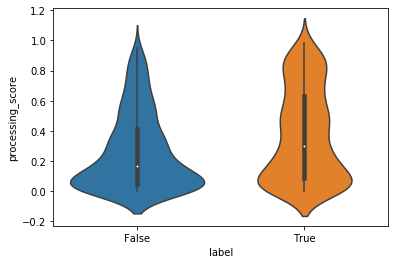

In [133]:
import seaborn
seaborn.violinplot(
    data=df_pred_subset, 
    y="processing_score",
    x="label")

In [115]:
from sklearn.metrics import roc_auc_score, f1_score

In [116]:
roc_auc_score(y_true=label_subset, y_score=df_pred_subset.processing_score.values)

0.6012050998619087

In [117]:
roc_auc_score(y_true=label_subset, y_score=df_pred_subset.presentation_score.values)

0.6124229592188172

In [118]:
roc_auc_score(y_true=label_subset, y_score=-df_pred_subset.affinity.values)

0.5990336896589049

In [119]:
roc_auc_score(y_true=label_subset, y_score=df_pred_subset.score.values)

0.6187846663014849

In [120]:
df_tcell_mouse_and_human_class1

,allele,peptide,fraction_entries_positive,num_entries,num_entries_with_subjects,num_subjects,num_subjects_positive,fraction_subjects_positive,in_sars2,species_prefix,species,mhc_gene_name,mhc_class,mhcflurry_allele_name
0,H2-Db,AAIENYVRF,1.000000,1,0,0.0,0.0,0.000000,False,H2,mouse,D,I,H-2-Db
1,H2-Db,AAVKNWMTQTL,1.000000,1,0,0.0,0.0,0.000000,False,H2,mouse,D,I,H-2-Db
2,H2-Db,AGPHNDMEI,0.863636,22,2,18.0,16.0,0.888889,False,H2,mouse,D,I,H-2-Db
3,H2-Db,ASNENMDAM,0.578947,19,0,0.0,0.0,0.000000,False,H2,mouse,D,I,H-2-Db
4,H2-Db,ASNENMDTM,1.000000,3,0,0.0,0.0,0.000000,False,H2,mouse,D,I,H-2-Db
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252,HLA-C*07:02,CRVLCCYVL,1.000000,1,0,0.0,0.0,0.000000,False,HLA,human,C,I,HLA-C*07:02
1253,HLA-C*07:02,FRKDVNMVL,1.000000,1,1,10.0,8.0,0.800000,False,HLA,human,C,I,HLA-C*07:02
1254,HLA-C*07:02,TPRVTGGGAM,1.000000,1,0,0.0,0.0,0.000000,False,HLA,human,C,I,HLA-C*07:02
1255,HLA-C*08:01,FLGPLLVLQA,1.000000,1,0,0.0,0.0,0.000000,False,HLA,human,C,I,HLA-C*08:01


In [121]:
df_pred

,peptide,peptide_num,sample_name,affinity,best_allele,processing_score,presentation_score
0,AAIENYVRF,0,H-2-Db,35.939434,H-2-Db,0.535547,0.915806
1,AAVKNWMTQTL,1,H-2-Db,54.257879,H-2-Db,0.146693,0.654062
2,AGPHNDMEI,2,H-2-Db,39.029623,H-2-Db,0.055071,0.646046
3,ASNENMDAM,3,H-2-Db,28.360595,H-2-Db,0.005191,0.669574
4,ASNENMDTM,4,H-2-Db,26.689156,H-2-Db,0.005358,0.681474
...,...,...,...,...,...,...,...
1209,CRVLCCYVL,1209,HLA-C*07:02,123.605679,HLA-C*07:02,0.001070,0.352100
1210,FRKDVNMVL,1210,HLA-C*07:02,34.151154,HLA-C*07:02,0.356372,0.857338
1211,TPRVTGGGAM,1211,HLA-C*07:02,4672.527432,HLA-C*07:02,0.390996,0.080797
1212,FLGPLLVLQA,1212,HLA-C*08:01,5290.585710,HLA-C*08:01,0.217904,0.040771


In [122]:
def f(x):
    return 1/(1 + np.exp( (3.5 * 10 **-4.0) * (x - 3)))

In [123]:
f(10000)

0.029342121196204007

In [124]:
xs = [1, 10, 100, 1000, 5000, 10000, 20000, 100000]
ys = [f(x) for x in xs]

In [125]:
import seaborn

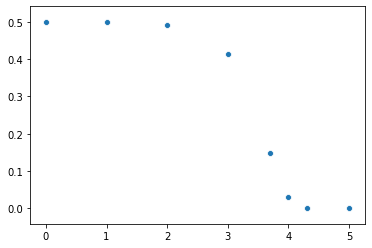

In [126]:
seaborn.scatterplot(np.log10(xs), ys)

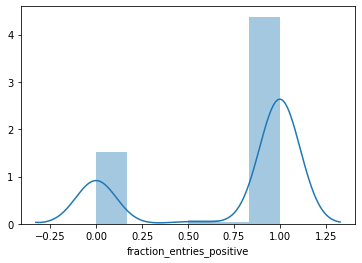

In [127]:
import seaborn 
seaborn.distplot(df_tcell[df_tcell["mhc_class"] == "II"].fraction_entries_positive)

HLA-DRA*01:01/DRB1*04:01    119
HLA-DRB1*01:02               61
HLA-DRB1*03:01               61
HLA-DRA*01:01/DRB1*04:04     55
HLA-DRB1*15:01               12
HLA-DRB5*01:01               10
HLA-DRB1*04:01                9
HLA-DRB1*01:03                8
HLA-DRB1*01:01                6
H2-IAb                        2
HLA-DRB1*11:01                2
HLA-DRB1*08:01                1
HLA-DRB1*07:01                1
H2-IA                         1
Name: allele, dtype: int64

HLA-DRB1*01:01              137
HLA-DRB1*11:01              126
HLA-DRB1*04:01              110
HLA-DRB1*07:01               95
HLA-DRB1*15:01               85
HLA-DRB1*04:04               74
HLA-DRB1*03:01               67
HLA-DRB5*01:01               65
HLA-DRB1*01:03               25
HLA-DRA*01:01/DRB1*04:01     25
HLA-DRA*01:01/DRB1*07:01     24
H2-IAb                       20
HLA-DRB1*11:04               18
HLA-DRB1*08:01               15
HLA-DRA*01:01/DRB1*04:04     12
HLA-DRB1*15:02               12
HLA-DRA*01:01/DRB1*01:01     11
HLA-DRB1*14:01               11
HLA-DRB1*13:01                8
HLA-DRB3*02:02                7
HLA-DRB1*01:02                4
HLA-DRB1*13:02                3
H2-IAd                        3
HLA-DRB1*09:01                3
HLA-DQB1*06:02                3
HLA-DRB1*12:01                2
HLA-DRB3*01:01                1
HLA-DPB1*04:01                1
Patr-DRB5*03:10               1
Name: allele, dtype: int64